# Load Dependencies and Check GPU Status

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np

# check if GPU is recognized
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Build Dataloading Function

In [2]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

### Plot Wave

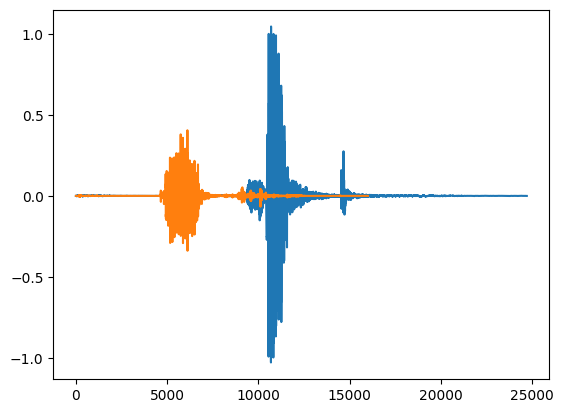

In [3]:
# raw data
BAD_FILE = os.path.join("C:/Users/jreye/ML_DATA/BadWords/fuck/fuck1.wav")
NOT_BAD_FILE = os.path.join("C:/Users/jreye/ML_DATA/NotBadWords/NotBad_comp/backward(1).wav")

wave = load_wav_16k_mono(BAD_FILE)
nwave = load_wav_16k_mono(NOT_BAD_FILE)

plt.plot(wave)
plt.plot(nwave)
plt.show()

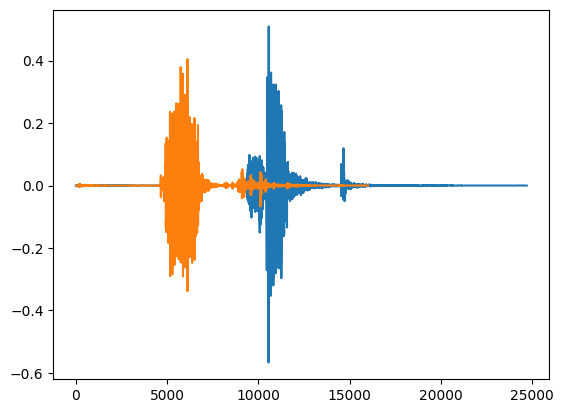

In [4]:
# normalized data
BAD_FILE = os.path.join("C:/Users/jreye/ML_DATA/BadWords/fuck_comp_all/fuck1.wav")
NOT_BAD_FILE = os.path.join("C:/Users/jreye/ML_DATA/NotBadWords/NotBad_comp/backward(1).wav")

wave = load_wav_16k_mono(BAD_FILE)
nwave = load_wav_16k_mono(NOT_BAD_FILE)

plt.plot(wave)
plt.plot(nwave)
plt.show()

# Create TensorFlow Dataset

In [47]:
# define paths to positive and negative data
NOT_BAD = os.path.join("C:/Users/jreye/ML_DATA/NotBadWords/NotBad_comp") 
FUCK = os.path.join("C:/Users/jreye/ML_DATA/BadWords/fuck_comp_all_44k") 
SHIT = os.path.join("C:/Users/jreye/ML_DATA/BadWords/shit_comp_all") 

# Create multi-classification datasets
not_bad = tf.data.Dataset.list_files(NOT_BAD+'\*.wav').map(lambda x: (x, tf.constant([1, 0, 0], dtype=tf.float32))) 
fuck = tf.data.Dataset.list_files(FUCK+'\*.wav').map(lambda x: (x, tf.constant([0, 1, 0], dtype=tf.float32))) 
shit = tf.data.Dataset.list_files(SHIT+'\*.wav').map(lambda x: (x, tf.constant([0, 0, 1], dtype=tf.float32))) 

data = not_bad.concatenate(fuck)
data = data.concatenate(shit)

print("Size of not_bad dataset: " + repr(len(not_bad)))
print("Size of fuck dataset   : " + repr(len(fuck)))
print("Size of shit dataset   : " + repr(len(shit)))

# for debugging
#list(fuck.as_numpy_iterator())

Size of not_bad dataset: 1850
Size of fuck dataset   : 1438
Size of shit dataset   : 1024


## Determine Average Length of Sample

In [6]:
# calculate wave cycle length
lengths = []

# not bad files
# for file in os.listdir(os.path.join(NOT_BAD)):
#      tensor_wave = load_wav_16k_mono(os.path.join(NOT_BAD, file))
#      lengths.append(len(tensor_wave))

# # # fuck 
# for file in os.listdir(os.path.join(FUCK)):
#      tensor_wave = load_wav_16k_mono(os.path.join(FUCK, file))
#      lengths.append(len(tensor_wave))
    
# # # shit
# for file in os.listdir(os.path.join(SHIT)):
#      tensor_wave = load_wav_16k_mono(os.path.join(SHIT, file))
#      lengths.append(len(tensor_wave))

In [7]:
# calculate mean
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [8]:
# calculate min
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=float32, numpy=inf>

In [9]:
# calculate max
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=float32, numpy=-inf>

In [10]:
# ave length of bad word
tf.math.reduce_mean(lengths)/16000

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [11]:
# min length of bad word
tf.math.reduce_min(lengths)/16000

<tf.Tensor: shape=(), dtype=float32, numpy=inf>

In [12]:
# max length of bad word
tf.math.reduce_max(lengths)/16000

<tf.Tensor: shape=(), dtype=float32, numpy=-inf>

# Build Preprocessing Function to Convert to Spectrogram

In [8]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:25000] # 35000 sample length (can make smaller to reduce processing time but will affect accuracy)
    zero_padding = tf.zeros([25000] - tf.shape(wav), dtype=tf.float32) 
    wav = tf.concat([zero_padding, wav],0) # pad clips longer than 25000 samples wiht zeros
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

[0. 0. 1.]


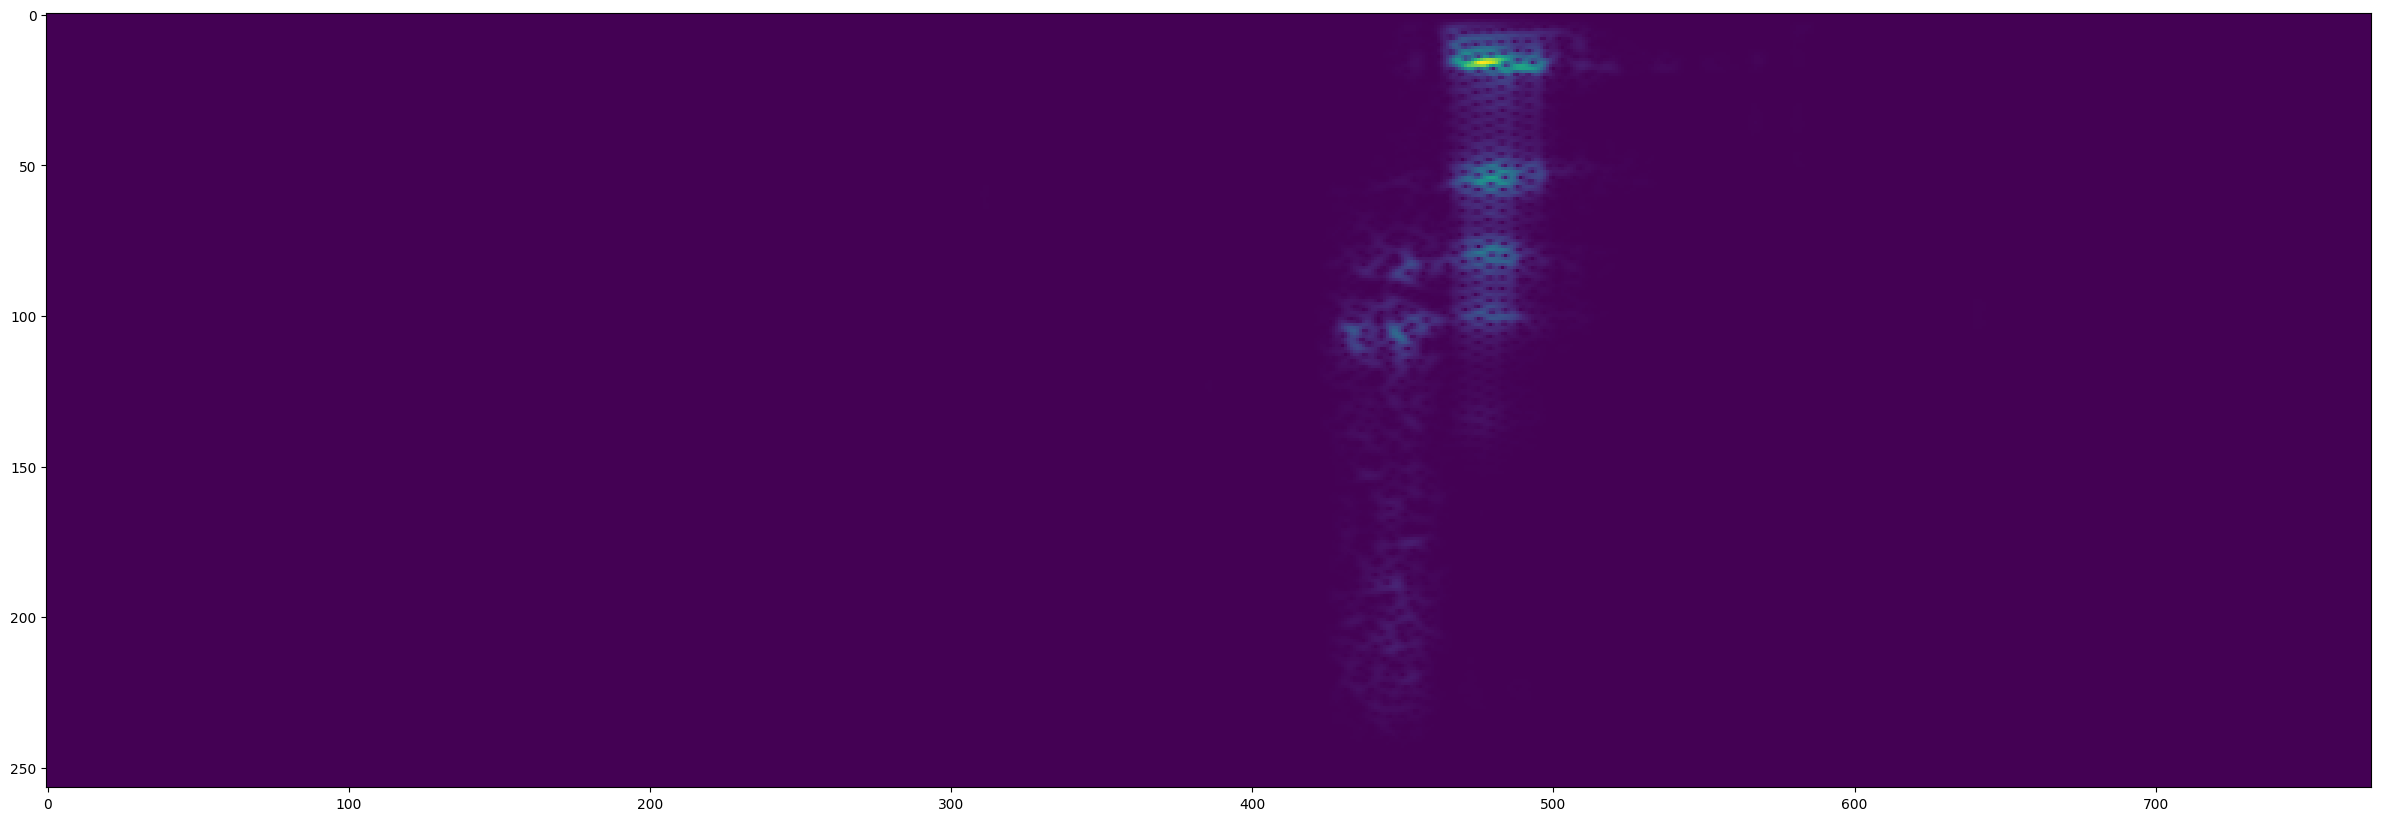

In [9]:
# test out the function and visualize the spectrogram (bad words)
# print from shit label
filepath, label = shit.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
print(label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Create Training and Testing Partitions

In [10]:
len(data)

4312

In [11]:
# create TensorFlow data pipeline
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=5000)
data = data.batch(16)
data = data.prefetch(8)

In [12]:
len(data)

270

In [13]:
len(data)*.7

189.0

In [14]:
len(data) - len(data)*.7

81.0

In [15]:
# split into training and testing partitions
train = data.take(189) # 70 % goes to train set
test = data.skip(189).take(81) # 30 % goes to test set

In [16]:
train = train.shuffle(buffer_size=5000)
test = test.shuffle(buffer_size=5000)

In [17]:
# test one batch
samples, labels = train.as_numpy_iterator().next()

In [18]:
samples.shape

(16, 772, 257, 1)

In [19]:
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

# Build Deep Learning Model

In [20]:
# load Keras Model dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Activation, Dropout, LayerNormalization, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard # to view statistics
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import CategoricalAccuracy, Recall, Precision

import time

# Training Various Configurations of Model

In [68]:
# test various configs of model
dense_layers = [0] # 1 worked well so we check 0 and 2
layer_sizes = [32] # 16 worked well so we check 8 and 32
conv_layers = [3] # 2 worked well so we check 1 and 3
dense_size = 128
epochs_num = 10

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            # create layers
            model = Sequential() 
            model.add(Conv2D(layer_size, (3,3), input_shape= (772, 257, 1))) # depends on shape of spec
            model.add(LayerNormalization())
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2,2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3,3)))
                model.add(LayerNormalization())
                model.add(Activation("relu"))
                #model.add(Dropout(0.2))
                model.add(MaxPooling2D(pool_size=(2,2)))

            model.add(Flatten())
            for l in range(dense_layer):                                                                                            
                model.add(Dense(dense_size))
                model.add(Activation("relu"))

            # output layer
            model.add(Dense(3))
            model.add(Activation("softmax"))  
   
            tensorboard = TensorBoard(log_dir='bad_mouth_logs/{}'.format(NAME))

            model.compile(optimizer='Adam', # adam optimizer (can change to small learning rate)
                          loss='CategoricalCrossentropy', 
                          metrics=[Recall(), Precision(), CategoricalAccuracy()])

            # tensorboard analysis
            hist = model.fit(train, epochs=epochs_num, validation_data=test, callbacks = [tensorboard])

3-conv-32-nodes-0-dense-1681599631
Epoch 1/10
189/189 [==============================] - 58s 303ms/step - loss: 5.8327 - recall_2: 0.5744 - precision_2: 0.5807 - categorical_accuracy: 0.5764 - val_loss: 6.7720 - val_recall_2: 0.2601 - val_precision_2: 0.2601 - val_categorical_accuracy: 0.2601
Epoch 2/10
189/189 [==============================] - 57s 303ms/step - loss: 1.7288 - recall_2: 0.6961 - precision_2: 0.6984 - categorical_accuracy: 0.6974 - val_loss: 2.2384 - val_recall_2: 0.7019 - val_precision_2: 0.7051 - val_categorical_accuracy: 0.7057
Epoch 3/10
189/189 [==============================] - 57s 301ms/step - loss: 1.4255 - recall_2: 0.7325 - precision_2: 0.7364 - categorical_accuracy: 0.7345 - val_loss: 2.4540 - val_recall_2: 0.7096 - val_precision_2: 0.7152 - val_categorical_accuracy: 0.7120
Epoch 4/10
189/189 [==============================] - 57s 300ms/step - loss: 0.5879 - recall_2: 0.8185 - precision_2: 0.8225 - categorical_accuracy: 0.8211 - val_loss: 1.4712 - val_recall_

# Fit Model, View Loss, and KPI Plots

In [69]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 770, 255, 32)      320       
                                                                 
 layer_normalization_5 (Laye  (None, 770, 255, 32)     64        
 rNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 770, 255, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 385, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 383, 125, 32)      9248      
                                                                 
 layer_normalization_6 (Laye  (None, 383, 125, 32)    

In [70]:
model.evaluate(test)

81/81 [==============================] - 10s 116ms/step - loss: 0.2703 - recall_2: 0.9262 - precision_2: 0.9335 - categorical_accuracy: 0.9317


[0.27031388878822327,
 0.9262422323226929,
 0.9334897994995117,
 0.9316770434379578]

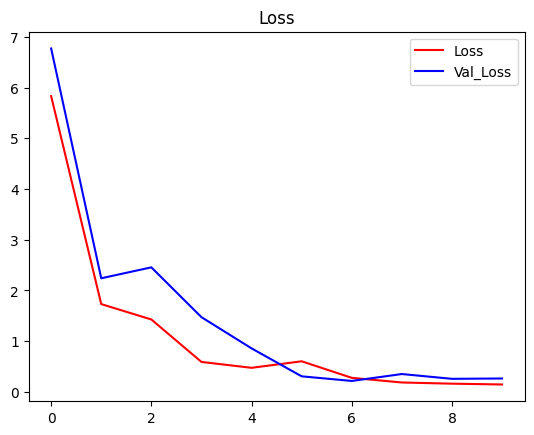

In [71]:
# plot loss 
# mean error across samples for each epoch (runthrough entire dataset)
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.legend(["Loss", "Val_Loss"])
plt.show()

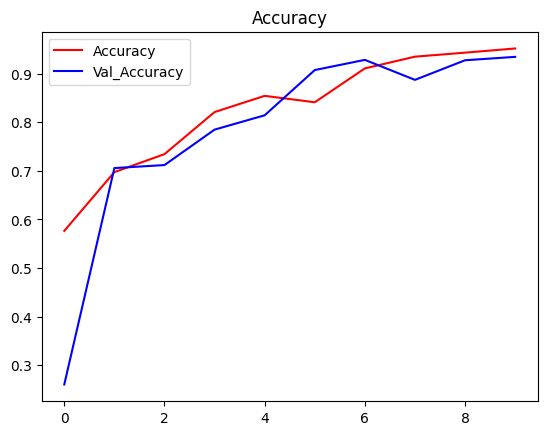

In [73]:
# plot Accuracy 
# mean error across samples for each epoch (runthrough entire dataset)
plt.title('Accuracy')
plt.plot(hist.history['categorical_accuracy'], 'r')
plt.plot(hist.history['val_categorical_accuracy'], 'b')
plt.legend(["Accuracy", "Val_Accuracy"])
plt.show()

# LOOKS LIKE OVERFITTING

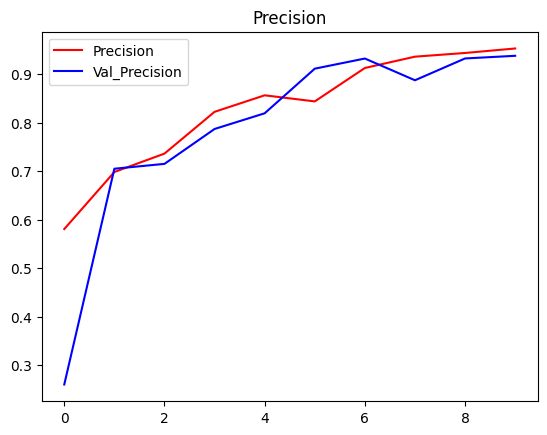

In [74]:
# plot precision
# the percent of positive predicitions that were correct (good and bad)
plt.title('Precision')
plt.plot(hist.history['precision_2'], 'r')
plt.plot(hist.history['val_precision_2'], 'b')
plt.legend(["Precision", "Val_Precision"])
plt.show()

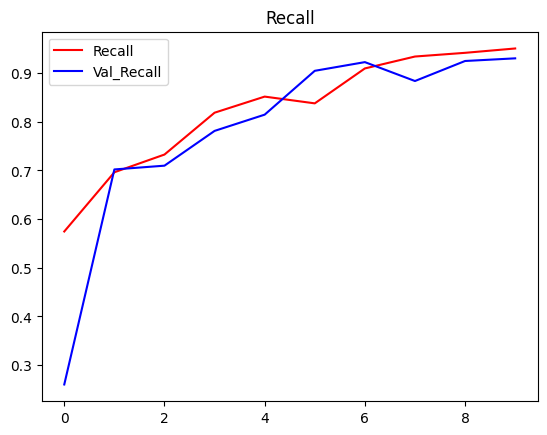

In [75]:
# plot recall
# the percentage of positive predicitions that were correct (only bad words)
plt.title('Recall')
plt.plot(hist.history['recall_2'], 'r')
plt.plot(hist.history['val_recall_2'], 'b')
plt.legend(["Recall", "Val_Recall"])
plt.show()

# Make a Prediction on a single batch

In [76]:
# get one batch and make a prediction
X_test, y_test = test.as_numpy_iterator().next()
print(X_test.shape)
yhat = model.predict(X_test)

# Convert logits to classes
y_pred = np.argmax(yhat, axis=1)
y_pred

# Convert true labels to class indices
y_test_indices = np.argmax(y_test, axis=1)



(16, 772, 257, 1)
1/1 [==============================] - 0s 116ms/step


## Confusion Matrix

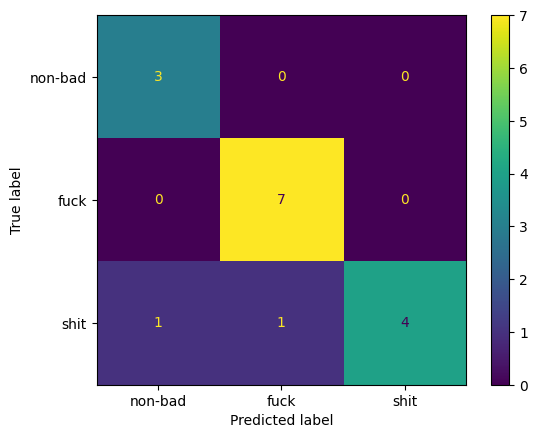

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_indices, y_pred)

# Use the class names as display labels
class_names = ['non-bad', 'fuck', 'shit']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()


# Save the Model

In [78]:
# todo: automate naming format
model.save('bad_mouth_3c_32n_0d_LN_10e_FUCK_SHIT_93acc.model')
# how to load model
# new_model = tf.keras.models.load_model('bad_mouth.model')

INFO:tensorflow:Assets written to: bad_mouth_3c_32n_0d_LN_10e_FUCK_SHIT_93acc.model\assets


INFO:tensorflow:Assets written to: bad_mouth_3c_32n_0d_LN_10e_FUCK_SHIT_93acc.model\assets


# Convert to TF Lite

In [79]:
TF_LITE_MODEL_FILE_NAME = "bad_mouth_lite.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File Size: ' + str(round(size /1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File Size: ' + str(round(size /(1024*1024), 3)) + ' Megabytes')
    else:
        return print('File Size: ' + str(size) + 'bytes')

INFO:tensorflow:Assets written to: C:\Users\jreye\AppData\Local\Temp\tmp33hpqhh3\assets


INFO:tensorflow:Assets written to: C:\Users\jreye\AppData\Local\Temp\tmp33hpqhh3\assets


In [80]:
# check input tensor shape
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "MB")

File Size: 1.124 Megabytes
